In [1]:
# Importing the necessary packages/libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
# Remove pandas duplication of the first column within the file
df = pd.read_csv('./churn_clean.csv', index_col=0)

In [3]:
# View data types and column information, dataframe as a whole
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_id           10000 non-null  object 
 1   Interaction           10000 non-null  object 
 2   UID                   10000 non-null  object 
 3   City                  10000 non-null  object 
 4   State                 10000 non-null  object 
 5   County                10000 non-null  object 
 6   Zip                   10000 non-null  int64  
 7   Lat                   10000 non-null  float64
 8   Lng                   10000 non-null  float64
 9   Population            10000 non-null  int64  
 10  Area                  10000 non-null  object 
 11  TimeZone              10000 non-null  object 
 12  Job                   10000 non-null  object 
 13  Children              10000 non-null  int64  
 14  Age                   10000 non-null  int64  
 15  Income                10

In [4]:
# Check for missing values
print(df.isnull().sum())

Customer_id                0
Interaction                0
UID                        0
City                       0
State                      0
County                     0
Zip                        0
Lat                        0
Lng                        0
Population                 0
Area                       0
TimeZone                   0
Job                        0
Children                   0
Age                        0
Income                     0
Marital                    0
Gender                     0
Churn                      0
Outage_sec_perweek         0
Email                      0
Contacts                   0
Yearly_equip_failure       0
Techie                     0
Contract                   0
Port_modem                 0
Tablet                     0
InternetService         2129
Phone                      0
Multiple                   0
OnlineSecurity             0
OnlineBackup               0
DeviceProtection           0
TechSupport                0
StreamingTV   

In [5]:
# Clean up and prepare the data
# Rename the Outage column for proper spacing and easier understanding
df = df.rename(columns={'Outage_sec_perweek': 'Outages'})

# Rename the Internetservice column for easier understanding
df = df.rename(columns={'InternetService': 'Internet'});

# Rename the Techsupport column for proper spacing
df = df.rename(columns={'TechSupport': 'Tech_Support'})

# Rename the Yearly_equip_failure column for easier understanding
df = df.rename(columns={'Yearly_equip_failure': 'Equipment_Failures'})

# Rename the Bandwidth_GB_Year column for proper spacing and easier understanding
df = df.rename(columns={'Bandwidth_GB_Year': 'Bandwidth_Usage'})

# Rename the Onlinesecurity column for proper spacing
df = df.rename(columns={'OnlineSecurity': 'Online_Security'});

# Rename the Onlinebackup column for proper spacing
df = df.rename(columns={'OnlineBackup': 'Online_Backup'});

# Rename the Streamingtv column for proper spacing
df = df.rename(columns={'StreamingTV': 'Streaming_TV'})

# Rename the Streamingmovies column for proper spacing
df = df.rename(columns={'StreamingMovies': 'Streaming_Movies'})

# Rename the Port_modem column for easier understanding
df = df.rename(columns={'Port_modem': 'Modem'})

#Drop null internet values, as we are only looking at customers with internet service
df.dropna(subset=['Internet'], inplace=True)

# Rename items in 'Contract' to better understand dummy variables in later analysis
df['Contract'] = df['Contract'].replace({'Month-to-month': 'Month', 'Two Year': 'Two' , 'One year' : 'One'})

# Minimalize decimal places in applicable columns to limit data points for better understanding of the data
df["Outages"] = df.Outages.round(2)
df["Equipment_Failures"] = df.Equipment_Failures.round(2)
df["Age"] = df.Age.round(2)
df["Income"] = df.Income.round(2)
df["Bandwidth_Usage"] = df.Bandwidth_Usage.round(2)

In [6]:
# Convert Multiple column to category from object
df["Multiple"] = df["Multiple"].astype("category")

# Convert Gender column to category from object
df["Gender"] = df["Gender"].astype("category")

# Convert Contract column to category from object
df["Contract"] = df["Contract"].astype("category")

# Convert Tech Support column to category from object
df["Tech_Support"] = df["Tech_Support"].astype("category")

# Convert Techie column to category from object
df["Techie"] = df["Techie"].astype("category")

# Convert Modem column to category from object
df["Modem"] = df["Modem"].astype("category")

# Convert Tablet column to category from object
df["Tablet"] = df["Tablet"].astype("category")

# Convert Streaming_TV column to category from object
df["Streaming_TV"] = df["Streaming_TV"].astype("category")

# Convert Streaming_Movies column to category from object
df["Streaming_Movies"] = df["Streaming_Movies"].astype("category")

# Convert Online_Security column to category from object
df["Online_Security"] = df["Online_Security"].astype("category")

# Convert Online_Backup column to category from object
df["Online_Backup"] = df["Online_Backup"].astype("category")

# Convert numeric values to int
df["Income"] = df["Income"].astype(int)
df["Children"] = df["Children"].astype(int) 
df["Age"] = df["Age"].astype(int) 
df["Tenure"] = df["Tenure"].astype(int) 
df["Bandwidth_Usage"] = df["Bandwidth_Usage"].astype(int); 
df["Equipment_Failures"] = df["Equipment_Failures"].astype(int);
df["Outages"] = df["Outages"].astype(int);
                                             
# Change all yes/no values to 1 or 0 by mapping
Cd_map = {'Yes': 1, 'No': 0};

# Apply the mapping to applicable columns
convert = ["Tech_Support" , "Multiple" , "Techie" , "Equipment_Failures" , "Modem" , "Tablet" ,
            "Online_Backup" , "Online_Security" ,"Streaming_Movies" , "Streaming_TV"]
df[convert] = df[convert].replace(Cd_map);

# Rename items in 'Internet' to better understand dummy variables in later analysis
df['Internet'] = df['Internet'].replace({'Fiber Optic': 'Optic', 'DSL': 'DSL'})

# Create a mapping of internet service to numeric values
Service_mapping = { 'Optic' : 1, 'DSL' : 0}

# Apply the mapping to create new binary columns for each survey score
Service_columns = ["Internet"]

for column in Service_columns:
    df[column] = df[column].map(Service_mapping).astype(int)

# Create dummy variables, keeping all data points
dummy_columns = ["Contract", "Gender" , "Area"]
df = pd.get_dummies(data=df, columns=dummy_columns, drop_first=False);

# Identify the names of the dummy columns
dummy_column_names = df.columns[df.columns.str.startswith(tuple(dummy_columns))]

# Convert the dummy columns to integers (0/1)
df[dummy_column_names] = df[dummy_column_names].astype(int)

# Drop unnecessary columns from df
Cdrop = ["Customer_id", "Interaction", "UID", "City", "County", "Lat", "Lng" , "Marital" ,
            "TimeZone", "Zip" , "Email", "Contacts", "Phone", "Tenure" , "Churn" ,
            "State", "Population", "Job" , "Phone" , "PaymentMethod" , "PaperlessBilling" , "DeviceProtection" ,
            "MonthlyCharge" , "Item1" , "Item2" , "Item3" , "Item4" , "Item5" , 
             "Item6" , "Item7" , "Item8"]
df.drop(columns=Cdrop, axis=1, inplace=True)

# View resulting dataframe
df.head()

,Children,Age,Income,Outages,Equipment_Failures,Techie,Modem,Tablet,Internet,Multiple,...,Bandwidth_Usage,Contract_Month,Contract_One,Contract_Two,Gender_Female,Gender_Male,Gender_Nonbinary,Area_Rural,Area_Suburban,Area_Urban
CaseOrder,,,,,,,,,,,,,,,,,,,,,
1,0,68,28561,7,1,0,1,1,1,0,...,904,0,1,0,0,1,0,0,0,1
2,1,27,21704,11,1,1,0,1,1,1,...,800,1,0,0,1,0,0,0,0,1
3,4,50,9609,10,1,1,1,0,0,1,...,2054,0,0,1,1,0,0,0,0,1
4,1,48,18925,14,0,1,0,0,0,0,...,2164,0,0,1,0,1,0,0,1,0
5,0,83,40074,8,1,0,1,0,1,0,...,271,1,0,0,0,1,0,0,1,0


In [7]:
# Check for missing values to ensure they were taken care of in previous step
print(df.isnull().sum())

Children              0
Age                   0
Income                0
Outages               0
Equipment_Failures    0
Techie                0
Modem                 0
Tablet                0
Internet              0
Multiple              0
Online_Security       0
Online_Backup         0
Tech_Support          0
Streaming_TV          0
Streaming_Movies      0
Bandwidth_Usage       0
Contract_Month        0
Contract_One          0
Contract_Two          0
Gender_Female         0
Gender_Male           0
Gender_Nonbinary      0
Area_Rural            0
Area_Suburban         0
Area_Urban            0
dtype: int64


In [8]:
# Save the cleaned DataFrame to CSV
df.to_csv('Clean_df.csv', index=False)

In [9]:
# Begin anaylsis by separating the X variables (features) from the Y variable (target)
Xdf2 = df.drop(["Internet"], axis=1)
Ydf2 = df["Internet"]

In [10]:
# Identify X and y for train/test split
X = Xdf2
y = Ydf2
# Split the data into train and test sets, 70% train 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size=0.3)

In [11]:
# Save each data set to CSV
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)
X_train_df.to_csv('X_train.csv', index=False)
X_test_df.to_csv('X_test.csv', index=False)
y_train_df.to_csv('y_train.csv', index=False)
y_test_df.to_csv('y_test.csv', index=False)

In [12]:
# Create and fit data to random forest classifier model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [13]:
# Make predictions with initial model
y_pred = rf.predict(X_test)

In [14]:
# Evaluate the model using accuracy, f1, MSE, confusion matrix and roc/auc
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
cmat = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
# Print scores
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(f"Mean Squared Error: {mse}");
print("Confusion Matrix:\n", cmat)
print("ROC AUC:", roc_auc)

Accuracy: 0.6232006773920407
F1 Score: 0.6903270702853167
Mean Squared Error: 0.37679932260795934
Confusion Matrix:
 [[480 544]
 [346 992]]
ROC AUC: 0.6618670590433483


In [15]:
# Complete hyperparameter Tuning to create final model
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022FB5D54590>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022FBC838ED0>})

In [16]:
# Create a variable for the best model
Final_best = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 11, 'n_estimators': 254}


In [17]:
# Generate predictions with the best model
y_pred = Final_best.predict(X_test)
Final_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, n_estimators=254)

In [18]:
# Evaluate the final model using accuracy, f1, MSE confusion matrix and roc/auc
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cmat = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, Final_best.predict_proba(X_test)[:, 1])
mse = mean_squared_error(y_test, y_pred)
# Print scores
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(f"Mean Squared Error: {mse}");
print("Confusion Matrix:\n", cmat)
print("ROC AUC:", roc_auc)

Accuracy: 0.6236240474174428
F1 Score: 0.7146067415730336
Mean Squared Error: 0.3763759525825571
Confusion Matrix:
 [[ 360  664]
 [ 225 1113]]
ROC AUC: 0.6522656541946936


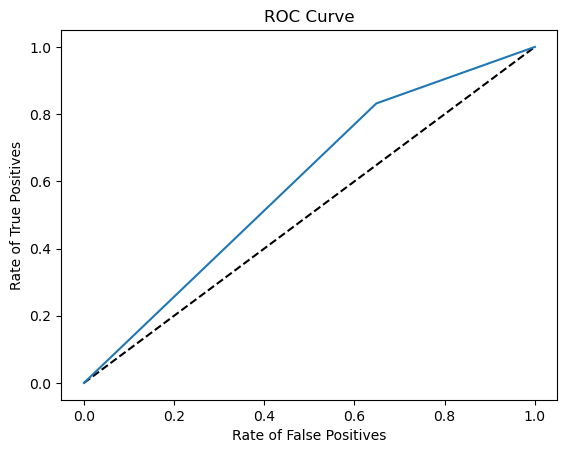

In [19]:
# Plot ROC Curve for reduced model
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('Rate of False Positives')
plt.ylabel('Rate of True Positives')
plt.title('ROC Curve')
plt.show()

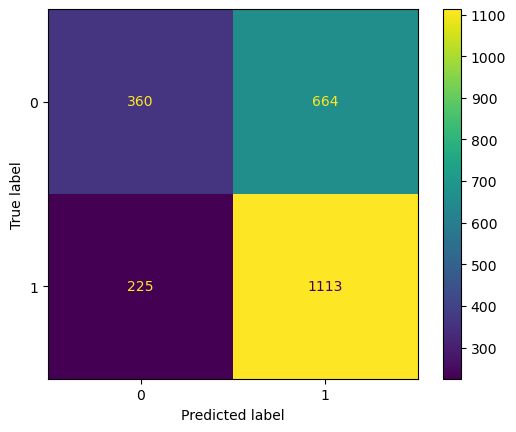

In [20]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [21]:
# Combine Xdf and Ydf into a new DataFrame named Cdf
Cdf = pd.concat([Xdf2, Ydf2.reset_index().drop('CaseOrder', axis=1)])

# Save the combined DataFrame to CSV
Cdf.to_csv('Cdf.csv', index=False)